# Classification with Deep Neural Networks 

## Load MNIST Dataset

In [100]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

In [101]:
from torchvision import datasets, transforms 

train : 60,000 / test : 10,000 

train -> 80%(train) / 20%(valid)

In [102]:
train = datasets.MNIST(
    '../data', train = True, download = True, 
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]),
)

test = datasets.MNIST(
    '../data', train = False, 
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [103]:
def plot(x) : 
    img = (np.array(x.detach().cpu(), dtype = 'float')).reshape(28, 28)
    
    plt.imshow(img, cmap = 'gray')
    plt.show()

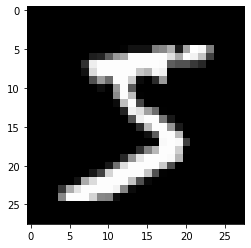

In [104]:
plot(train.data[0])

In [105]:
X = train.data.float()/ 255.
y = train.targets

X = X.view(X.size(0), -1)
print(X.shape, y.shape)

input_size = X.size(-1)
output_size = int(max(y)) + 1 

print('input size : %d, output size : %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input size : 784, output size : 10


In [106]:
# Train / Valid ratio 
ratios = [.8, .2]

train_cnt = int(X.size(0)*ratios[0])
valid_cnt = int(X.size(0)*ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print('Train %d / Valid %d / Test %d samples' % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(X.size(0))

X = torch.index_select(X, dim = 0, index = indices)
y = torch.index_select(y, dim = 0, index = indices)

X = list(X.split(cnts, dim = 0))
y = list(y.split(cnts, dim = 0))

X += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for X_i, y_i in zip(X, y) : 
    print(X_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [107]:
y[0].shape

torch.Size([48000])

## Build Model & Optimizer 

In [108]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim = -1),
)

model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

$\hat{y_i} = f_\theta(x)$

$\hat{y_i}$ : log(확률값) [0~9 : 10개]

$\hat{y_i} \in \mathbb{R}^{bs \times 10}$, $x \in \mathbb{R}^{bs \times 784}$

In [109]:
crit = nn.NLLLoss()

In [110]:
optimizer = optim.Adam(model.parameters())

## Move to GPU if it is available 

In [111]:
device = torch.device('cpu')
if torch.cuda.is_available() : 
    device = torch.device('cude')
else : 
    print('Not available')

Not available


In [112]:
model = model.to(device)
X = [X_i.to(device) for X_i in X]
y = [y_i.to(device) for y_i in y]

## Train 

In [113]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [114]:
from copy import deepcopy 

lowest_loss = np.inf 
best_model = None 

early_stop = 50 
lowest_epoch = np.inf 

In [115]:
train_history, valid_history = [], [] 

for i in range(n_epochs) : 
    indices = torch.randperm(X[0].size(0)).to(device)
    X_ = torch.index_select(X[0], dim = 0, index = indices)
    y_ = torch.index_select(y[0], dim = 0, index = indices)
    
    X_ = X_.split(batch_size, dim = 0)
    y_ = y_.split(batch_size, dim = 0)
    
    train_loss, valid_loss = 0, 0 
    y_hat = []
    
    for X_i, y_i in zip(X_, y_) : 
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        optimizer.zero_grad() # initialize 
        loss.backward() # loss optimizing 
        
        optimizer.step()
        train_loss += float(loss) # float!
        
    train_loss = train_loss / len(X_)
    
    with torch.no_grad() : 
        X_ = X[1].split(batch_size, dim = 0)
        y_ = y[1].split(batch_size, dim = 0) 
        
        valid_loss = 0

        for X_i, y_i in zip(X_, y_) : 
            y_hat_i = model(X_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            y_hat += [y_hat_i]
    
    valid_loss = valid_loss / len(X_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if ( i + 1 ) % print_interval == 0 : 
        print('Epoch %d : train loss = %.4e valid loss = %.4e lowest loss = %.4e' % (
        i + 1,
        train_loss,
        valid_loss,
        lowest_loss))
    
    if valid_loss <= lowest_loss : 
        lowest_loss = valid_loss
        lowest_epoch = i 
        best_model = deepcopy(model.state_dict())
              
    else :
        if early_stop > 0 and lowest_epoch + early_stop < i + 1 : 
            print('There is no improvement during last %d epochs.' % early_stop)
            break
    
print('The best validation loss from epoch %d : %.4e' % (lowest_epoch, lowest_loss))
model.load_state_dict(best_model)    

Epoch 10 : train loss = 2.6646e-02 valid loss = 1.1733e-01 lowest loss = 8.9230e-02
Epoch 20 : train loss = 1.2370e-02 valid loss = 1.0922e-01 lowest loss = 8.9230e-02
Epoch 30 : train loss = 5.3749e-03 valid loss = 1.2958e-01 lowest loss = 8.9230e-02
Epoch 40 : train loss = 4.7514e-03 valid loss = 1.2786e-01 lowest loss = 8.9230e-02
Epoch 50 : train loss = 4.2124e-03 valid loss = 1.2091e-01 lowest loss = 8.9230e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 6 : 8.9230e-02


<All keys matched successfully>

## Loss History

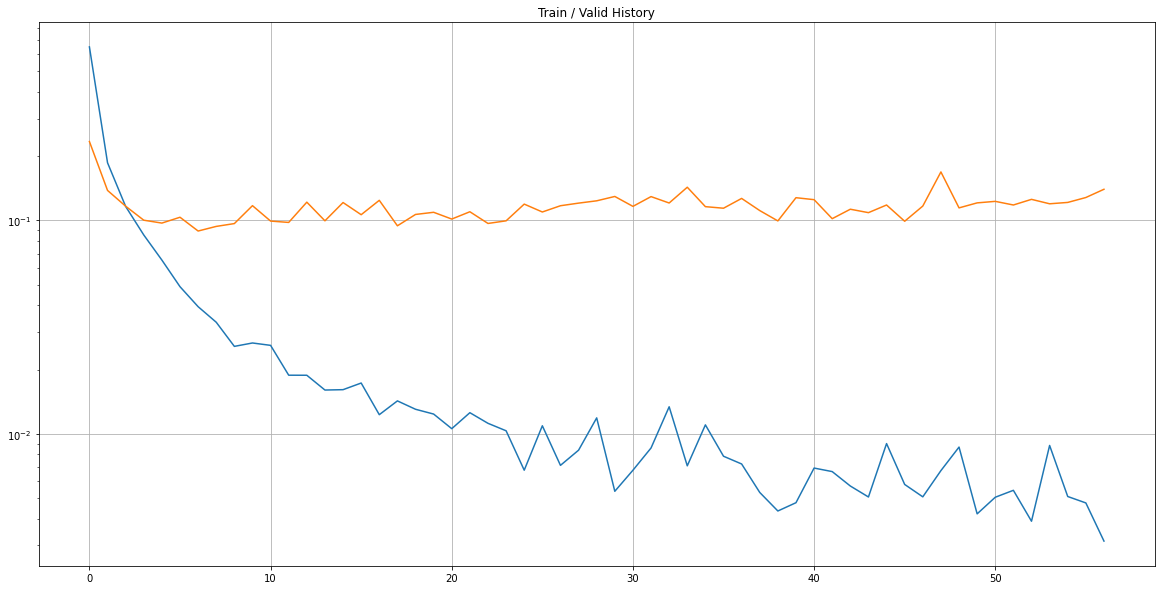

In [121]:
plot_from = 0

plt.figure(figsize = (20, 10))
plt.grid(True)
plt.title('Train / Valid History')
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)

plt.yscale('log')
plt.show()

## Result 

In [122]:
test_loss = 0
y_hat = []

with torch.no_grad() : 
    X_ = X[-1].split(batch_size, dim = 0)
    y_ = y[-1].split(batch_size, dim = 0)
    
    for X_i, y_i in zip(X_, y_) : 
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i)
        
        test_loss += loss 
        
        y_hat += [y_hat_i]
        
test_loss = test_loss/len(X_)
y_hat = torch.cat(y_hat, dim = 0)
print('Validation loss : %.4e' % test_loss)

Validation loss : 8.9872e-02


In [123]:
correct_cnt = (y[2].squeeze() == torch.argmax(y_hat, dim = -1)).sum()
total_cnt = float(y[2].size(0))

print('Accuracy : %.4f' % (correct_cnt / total_cnt))

Accuracy : 0.9748


In [124]:
import pandas as pd 
from sklearn.metrics import confusion_matrix

In [125]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim = -1)),
            index = ['true_%d' % i for i in range(10)],
            columns = ['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,962,0,1,1,3,2,6,1,1,3
true_1,0,1119,1,0,0,3,6,0,6,0
true_2,2,2,1002,3,2,0,1,9,11,0
true_3,0,0,6,980,0,8,0,5,6,5
true_4,1,0,0,0,966,0,7,3,0,5
true_5,2,0,0,6,3,865,4,1,5,6
true_6,1,2,0,0,8,5,940,0,2,0
true_7,1,2,9,2,1,0,0,1005,3,5
true_8,2,0,2,5,9,6,5,3,938,4
true_9,1,2,0,2,15,1,0,14,3,971
